`ppdire.py` subpackage: examples
================================
Here, we will illustrate how to use `ppdire.py` to perform different types of projection pursuit dimension reduction. 

To run a toy example, start by sourcing packages and data: 

In [1]:
# Load data
import pandas as ps
import numpy as np
data = ps.read_csv("../data/Returns_shares.csv")
columns = data.columns[2:8]
(n,p) = data.shape
datav = np.array(data.values[:,2:8].astype('float64'))
y = datav[:,0]
X = datav[:,1:5]
        
# Scale data
from direpack import VersatileScaler
centring = VersatileScaler()
Xs = centring.fit_transform(X)

1\. Comparison of PP estimates to Scikit-Learn 
======================================
Let us at first run `ppdire` to produce slow, approximate PP estimates of 
PCA and PLS. This makes it easy to verify that the algorithm is correct. 
        
1\.1\. PCA
--------------
By setting the projection index to variance, projection pursuit is a slow, approximate way to calculate PCA. Let's compare the `ppdire` results to `sklearn`'s.

- PCA ex `scikit-learn` 

In [2]:
import sklearn.decomposition as skd
skpca = skd.PCA(n_components=4)
skpca.fit(Xs)
skpca.components_.T # sklearn outputs loadings as rows ! 

array([[ 0.6160923 ,  0.09574799, -0.27553202,  0.73167254],
       [ 0.3612025 ,  0.79963754,  0.40566716, -0.25602091],
       [ 0.57369773, -0.2220554 , -0.47175995, -0.63166832],
       [ 0.40104108, -0.54963945,  0.73277473,  0.01018414]])

- PCA ex `ppdire`, using SLSQP optimization 

In [3]:
from direpack import dicomo, ppdire
pppca = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'var'}, n_components=4, optimizer='SLSQP')
pppca.fit(X)
pppca.x_loadings_

array([[-0.61607419,  0.09583096,  0.27564672, -0.73163589],
       [-0.36117419,  0.79968851, -0.40559673,  0.25604175],
       [-0.57366555, -0.22197834,  0.47186541,  0.63170272],
       [-0.40114044, -0.54958195, -0.73270268, -0.01015973]])

- PCA ex `ppdire`, using its native `grid` algorithm optimization \[1\].

In [4]:
pppca = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'var'}, n_components=4, optimizer='SLSQP',optimizer_options={'ndir':1000,'maxiter':1000})
pppca.fit(X)
pppca.x_loadings_

C:\Users\serneels\AppData\Local\anaconda3\Lib\site-packages\direpack\ppdire\ppdire.py:645: OptimizeWarning: Unknown solver options: ndir
  wi = minimize(pp_objective,


array([[-0.61607419,  0.09583096,  0.27564672, -0.73163589],
       [-0.36117419,  0.79968851, -0.40559673,  0.25604175],
       [-0.57366555, -0.22197834,  0.47186541,  0.63170272],
       [-0.40114044, -0.54958195, -0.73270268, -0.01015973]])

- PCR: 

In [5]:
pppca.fit(X,y=y)
pppca.fitted_

array([[-0.27208478],
       [ 0.83947294],
       [-0.22658715],
       ...,
       [-0.03175912],
       [-0.10768766],
       [ 0.26840235]])

In [104]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(skpca.components_,y)
lm.predict(pppca.x_scores_)

array([-0.27208478,  0.83947294, -0.22658715, ..., -0.03175912,
       -0.10768766,  0.26840235])

1\.2\. PLS 
----------
Likewise, by setting the projection index to covariance, one obtains partial least squares. 

- PLS ex `scikit-learn`

In [108]:
import sklearn.cross_decomposition as skc
skpls = skc.PLSRegression(n_components=4)
skpls.fit(Xs,(y-np.mean(y)).ravel()/np.std(y))
skpls.x_scores_
print(skpls.coef_.shape) 
np.matmul(Xs,skpls.coef_.transpose())*np.std(y) + np.mean(y)

(1, 4)


array([[-0.27212755],
       [ 0.83959019],
       [-0.22662337],
       ...,
       [-0.03176729],
       [-0.10770676],
       [ 0.26843739]])

- PLS ex `ppdire`, using SLSQP optimization 

In [109]:
pppls = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'cov'}, n_components=4, square_pi=False, optimizer='SLSQP', optimizer_options={'maxiter':500})
pppls.fit(X,y)
pppls.x_scores_
print(pppls.coef_scaled_) # Column 4 should agree with skpls.coef_
pppls.fitted_  

[[ 0.27190446  0.33122054  0.35628291  0.35734814]
 [ 0.05506195 -0.04547853 -0.04113433 -0.04417198]
 [ 0.23907241  0.25452063  0.22888164  0.22632364]
 [ 0.10731098  0.0461689   0.04141709  0.04614   ]]


array([[-0.27208478],
       [ 0.83947294],
       [-0.22658715],
       ...,
       [-0.03175912],
       [-0.10768766],
       [ 0.26840235]])

In [110]:
pppls = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'cov'}, n_components=4, square_pi=True, optimizer='IPOPT', optimizer_options={'maxiter':500})
pppls.fit(X,y)
pppls.x_scores_
print(pppls.coef_scaled_) # Column 4 should agree with skpls.coef_
pppls.fitted_  

C:\Users\serneels\AppData\Local\anaconda3\Lib\site-packages\direpack\ipopt_temp\ipopt_wrapper.py:203: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  nlp = cyipopt.problem(n = len(_x0),
C:\Users\serneels\AppData\Local\anaconda3\Lib\site-packages\cyipopt\utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


[[ 0.27190611  0.33122169  0.35628285  0.35734814]
 [ 0.05505942 -0.0454783  -0.04113419 -0.04417198]
 [ 0.23906983  0.25451947  0.22888159  0.22632364]
 [ 0.10731458  0.04616881  0.0414173   0.04614   ]]


array([[-0.27208478],
       [ 0.83947294],
       [-0.22658715],
       ...,
       [-0.03175912],
       [-0.10768766],
       [ 0.26840235]])

- PLS ex `ppdire`, `grid` optimization

In [12]:
pppls = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'cov'}, n_components=4, square_pi=True, optimizer='grid',optimizer_options={'ndir':1000,'maxiter':1000})
pppls.fit(X,y)
pppls.x_scores_
print(pppls.coef_scaled_) # Column 4 should agree with skpls.coef_
pppls.fitted_  

1
2
1
2
1
2
1
2
[[ 0.27197566  0.33138071  0.35633098  0.35734814]
 [ 0.05543391 -0.0453769  -0.04118079 -0.04417198]
 [ 0.23857626  0.25436242  0.22879951  0.22632364]
 [ 0.10758362  0.04611615  0.04150847  0.04614   ]]


array([[-0.27208478],
       [ 0.83947294],
       [-0.22658715],
       ...,
       [-0.03175912],
       [-0.10768766],
       [ 0.26840235]])

In [13]:
pppls2 = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'continuum'}, alpha=1, n_components=4, square_pi=True, optimizer='grid',optimizer_options={'ndir':1000,'maxiter':1000})
pppls.fit(X,y)
pppls.x_scores_
print(pppls.coef_scaled_) # Column 4 should agree with skpls.coef_
pppls.fitted_  

1
2
1
2
1
2
1
2
[[ 0.27197566  0.33138071  0.35633098  0.35734814]
 [ 0.05543391 -0.0453769  -0.04118079 -0.04417198]
 [ 0.23857626  0.25436242  0.22879951  0.22632364]
 [ 0.10758362  0.04611615  0.04150847  0.04614   ]]


array([[-0.27208478],
       [ 0.83947294],
       [-0.22658715],
       ...,
       [-0.03175912],
       [-0.10768766],
       [ 0.26840235]])

Remark: Dimension Reduction techniques based on projection onto latent variables, 
such as PCA, PLS and ICA, are sign indeterminate with respect to the components. 
Therefore, signs of estimates by different algorithms can be opposed, yet the 
absolute values should be identical up to algorithm precision.  Here, this implies
that `sklearn` and `ppdire`'s `x_scores_` and `x_loadings` can have opposed signs,
yet the coefficients and fitted responses should be identical. 

2\. Robust projection pursuit estimators
=================================

Note that optimization through `scipy.optimize` is much more efficient than the native `grid` algorithm, yet will only provide correct results for classical projection indices. The native `grid` algorithm should be used when 
the projection index involves order statistics of any kind, such as ranks, trimming, winsorizing, or empirical quantiles.

- Robust PCA based on the Median Absolute Deviation (MAD) \[2\]. 

In [8]:
lcpca = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'var', 'center': 'median'}, n_components=4, optimizer='grid',optimizer_options={'ndir':1000,'maxiter':10})
#set a higher maxiter for convergence and precision! 
lcpca.fit(X)
lcpca.x_loadings_

1
2
3
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
1
2


array([[ 0.6324543 , -0.00651997, -0.35820225,  0.6438448 ],
       [ 0.44750274, -0.67228343,  0.4950862 , -0.21806968],
       [ 0.53378114,  0.28794634, -0.46650197, -0.72699245],
       [ 0.35432068,  0.68524337,  0.64350842,  0.09692107]])

To extend to Robust PCR, just add `y` and `regopt = robust`: 

In [9]:
lcpca = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'var', 'center': 'median'}, n_components=4, optimizer='grid',optimizer_options={'ndir':1000,'maxiter':10},regopt='robust',square_pi=True)
lcpca.fit(X,y=y)
lcpca.x_loadings_
lcpca.x_scores_
lcpca.coef_scaled_
lcpca.predict(X[:2666])

1
2
3
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
1
2


array([-0.17676037,  0.7036929 , -0.21218902, ...,  0.11876807,
        0.23188034, -0.49625196])

- Robust Continuum Regression \[4\] based on trimmed continuum association: 

In [111]:
rcr = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'continuum'}, n_components=4, trimming=0.2, soft_trim=False, alpha=.9, optimizer='grid',optimizer_options={'ndir':1000,'maxiter':2500},square_pi=False,regopt='robust')
rcr.fit(X,y=y)
rcr.x_loadings_
rcr.x_scores_
rcr.coef_scaled_
rcr.fitted_

1
2
1
2
3
4
5
6
1
2
3
1
2


array([[-0.17203243],
       [ 0.76751053],
       [-0.23144196],
       ...,
       [-0.06028048],
       [-0.08524319],
       [ 0.34510628]])

In [112]:
rcr2 = ppdire(projection_index = dicomo, pi_arguments = {'mode': 'continuum'}, alpha= .9, n_components=4, trimming=0.2, soft_trim=True, square_pi=False, optimizer='SLSQP',optimizer_options={'maxiter':50000,'ftol': 1e-9},regopt='robust')
rcr2.fit(X,y=y)
rcr2.x_loadings_
rcr2.x_scores_
rcr2.coef_scaled_
rcr2.fitted_

array([[-0.17968447],
       [ 0.77862687],
       [-0.23554174],
       ...,
       [-0.05416643],
       [-0.08695268],
       [ 0.32841992]])

In [113]:
rcr3 = ppdire(projection_index = dicomo, pi_arguments = {'mode': 'continuum'}, alpha= .9, n_components=4, trimming=0.2, soft_trim=True, square_pi=False, optimizer='IPOPT',optimizer_options={'tol':1e-9},regopt='robust')
rcr3.fit(X,y=y)
rcr3.x_loadings_
rcr3.x_scores_
rcr3.coef_scaled_
rcr3.fitted_

array([[-0.17281061],
       [ 0.76901071],
       [-0.2322118 ],
       ...,
       [-0.05966695],
       [-0.08567557],
       [ 0.34304424]])

In [89]:
rcr.coef_scaled_

array([[ 0.25917463,  0.31791147,  0.34922553,  0.35734814],
       [ 0.07179608, -0.04501536, -0.03612945, -0.04417198],
       [ 0.23312968,  0.26513965,  0.2385172 ,  0.22632364],
       [ 0.11702621,  0.05159816,  0.03397169,  0.04614   ]])

In [90]:
rcr2.coef_scaled_

array([[ 0.25928044,  0.31793076,  0.34927729,  0.35734814],
       [ 0.0718799 , -0.04505083, -0.03621581, -0.04417198],
       [ 0.23331546,  0.26509692,  0.2384731 ,  0.22632364],
       [ 0.11657139,  0.05166868,  0.03399579,  0.04614   ]])

In [91]:
rcr3.coef_scaled_

array([[ 0.25928041,  0.31793085,  0.3236645 ,  0.35734814],
       [ 0.07187995, -0.04505077, -0.05186423, -0.04417198],
       [ 0.23331542,  0.26509689,  0.25586478,  0.22632364],
       [ 0.11657143,  0.05166853,  0.06219087,  0.04614   ]])

Let us now plot the results. The `plot` subpackage contains a plotting function for `ppdire`. To plot predicted vs. actual values:

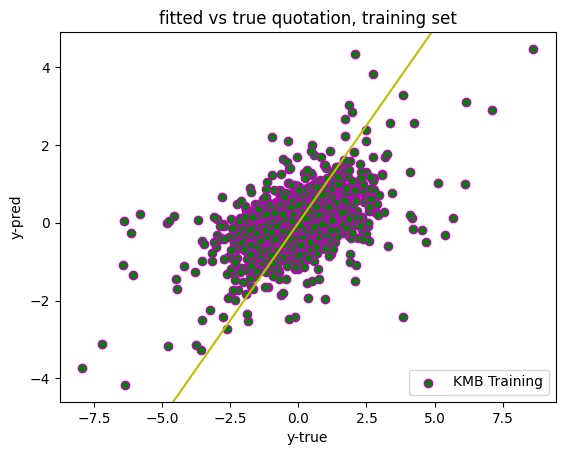

In [11]:
from direpack import ppdire_plot
dr_plot=ppdire_plot(rcr,['w','w','g','y','m','b','k'])
dr_plot.plot_yyp(label='KMB',title='fitted vs true quotation, training set')

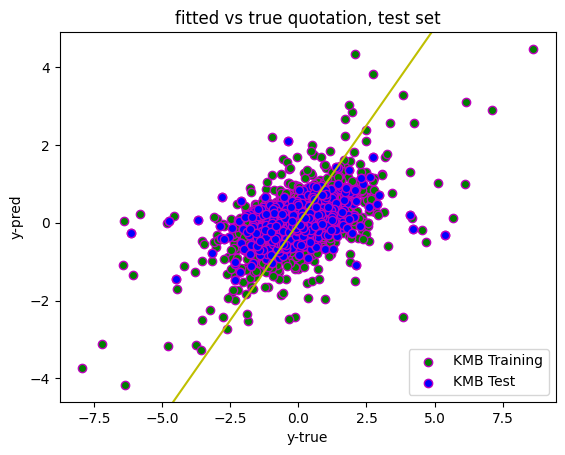

In [12]:
dr_plot.plot_yyp(ytruev=y[2666:],Xn=X[2666:],label='KMB',title='fitted vs true quotation, test set')

To plot scores: 

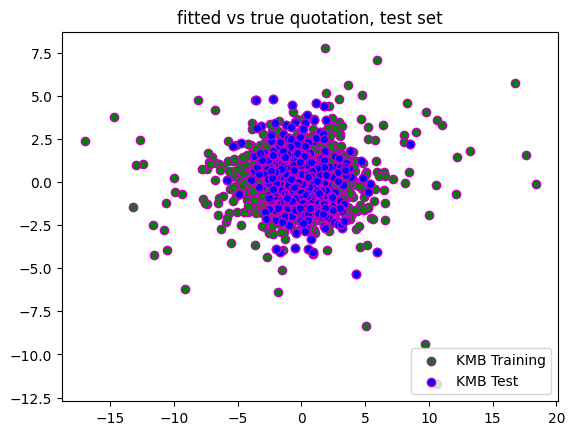

In [13]:
dr_plot.plot_projections(Xn=X[2666:],label='KMB',title='fitted vs true quotation, test set')

3\. Projection pursuit generalized betas
================================

Generalized betas are obtained as the projection pursuit weights using the 
co-moment analysis projection index (CAPI) \[2\]. 

In [14]:
from direpack import capi 
est = ppdire(projection_index = capi, pi_arguments = {'max_degree' : 3,'projection_index': dicomo, 'scaling': False}, n_components=1, trimming=0,center_data=True,scale_data=True)
est.fit(X,y=y,ndir=200)
est.x_weights_

array([[ 0.89537008],
       [-0.14912599],
       [ 0.03742244],
       [ 0.41793949]])

Note that these data aren't the greatest illustration. Evaluating CAPI projections, makes more sense if y is a market index, e.g. SPX. 

4\. Cross-validating through `scikit-learn` 
===========================================

The `ppdire` class is 100% compatible with `scikit-learn`, which allows, for instance, hyperparameter tuning through `GridSearchCV`. 
To try out, uncomment the line below and run. (this may take some time). 

In [15]:
# Uncomment to try out:

# from sklearn.model_selection import GridSearchCV
# rcr_cv = GridSearchCV(ppdire(projection_index=dicomo, 
#                                    pi_arguments = {'mode' : 'continuum'
#                                                    }, 
#                                    optimizer = 'grid',
#                                   optimizer_options = {'ndir':1000,'maxiter':1000}
#                                   ), 
#                             cv=10, 
#                             param_grid={"n_components": [1, 2, 3], 
#                                         "alpha": np.arange(.1,3,.3).tolist(),
#                                         "trimming": [0, .15]
#                                        }
#                            )
#       rcr_cv.fit(X[:2666],y[:2666]) 
#       rcr_cv.best_params_
#       rcr_cv.predict(X[2666:])

5\. Data compression
=================
While `ppdire` is very flexible and can project according to a very wide variety 
of projection indices, it can be computationally demanding. For flat data tables,
a workaround has been built in. However, not that running the code in the next field can take quite some time nonetheless.   

In [16]:
# Load flat data 
datan = ps.read_csv("../data/Glass_df.csv")
X = datan.values[:,100:300]
y = datan.values[:,2]
        
# Now compare
rcr = ppdire(projection_index = dicomo, 
                    pi_arguments = {'mode' : 'continuum'}, 
                    n_components=4, 
                    trimming=.1, 
                    alpha=.5, 
                    compression = False, 
                    optimizer='grid',
                    optimizer_options={'ndir':1000,'maxiter':1000})
rcr.fit(X,y)
print(rcr.coef_)
        
rcr = ppdire(projection_index = dicomo, 
                    pi_arguments = {'mode' : 'continuum'}, 
                    n_components=4, 
                    trimming=.1, 
                    alpha=.5, 
                    compression = True, 
                    optimizer='grid',
                    optimizer_options={'ndir':1000,'maxiter':1000})
rcr.fit(X,y)
rcr.coef_

1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
1
2
[[-4.71006531e-05 -1.73132209e-05 -2.32341283e-05  1.92662729e-05]
 [-4.91739225e-05 -2.17947308e-05 -2.87668265e-05  1.20306899e-05]
 [-5.12759847e-05 -1.42524723e-05 -1.93896027e-05  3.01898039e-05]
 [-5.52807363e-05 -1.16097279e-05 -1.61289191e-05  3.89100248e-05]
 [-6.40861390e-05 -2.28662497e-05 -3.16943089e-05  2.28228633e-05]
 [-7.48150962e-05 -1.73256629e-05 -2.46603844e-05  4.64485391e-05]
 [-9.23330952e-05 -1.00954653e-05 -1.93254855e-05  7.29662769e-05]
 [-1.15254313e-04 -7.55476110e-06 -1.78942404e-05  9.62501844e-05]
 [-1.47591582e-04  1.82604412e-05  9.50671369e-06  1.71444482e-04]
 [-1.61291766e-04  1.09591453e-04  1.11139450e-04  3.23510785e-04]
 [-1.70482657e-04  3.03507364e-04  3.33934289e-04  6.62455264e-04]
 [-1.45179276e-04  5.85905143e-04  6.65129657e-04  1.10966356e-03]
 [-7.77104871e-05  8.64100138e-04  9.93342063e-04  1.53689877e-03]
 [ 2.11272402e-05  1.29104873e-03  1.50740200e-03  2.22823988e-03]
 [ 7.15290516e-05  1.5

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


array([[-1.71734083e-03,  9.89246839e-03,  1.03132041e-02,
         1.23950958e-02],
       [-1.18750786e-03,  7.82790568e-04,  1.56385213e-04,
         4.86985132e-03],
       [ 3.42615075e-03, -1.02674075e-03, -1.02432021e-03,
        -2.68402298e-03],
       [ 7.20459942e-03,  1.16306226e-02,  1.14398455e-02,
         1.27104444e-02],
       [-7.45358004e-03, -9.26351554e-03, -1.07302614e-02,
        -1.32082506e-02],
       [-5.35992939e-05,  4.69698462e-03,  5.35924092e-03,
         4.86090170e-03],
       [-3.99197872e-03, -2.46572486e-02, -2.43193644e-02,
        -2.73214854e-02],
       [-7.82281660e-04, -1.22765531e-02, -1.35454735e-02,
        -1.57319221e-02],
       [-4.14575962e-03, -1.20971538e-03, -1.06979268e-03,
         3.54833732e-03],
       [-4.11097072e-03,  2.33337829e-03,  4.83267762e-03,
         5.30653152e-03],
       [-1.76870631e-03, -1.16439795e-02, -1.02689563e-02,
        -1.66622433e-02],
       [ 1.59799088e-03, -2.44734705e-04, -2.91311070e-03,
      

6\. Computation Time Comparisons
==================================

In [18]:
import timeit 

dimensions = [2,20,200]
cases = [50,500,5000,50000]
lvs = [1,3,5]

l = lvs[0]
d = dimensions[0]

resultsc = np.zeros((len(cases),7))

for i,c in enumerate(cases):
    for j,d in enumerate(dimensions):
        for k,l in enumerate(lvs):
            if l > d: 
                continue
            print(f"Running {c} cases, {l} LVs, {d} dimensions")
            loadings = np.random.uniform(1,5,(l,d))
            scores = np.random.multivariate_normal(np.zeros(l),np.diag(np.ones(l)),c)
            data = np.matmul(scores,loadings) + np.random.normal(0,0.02,(c,d))
            gamma = np.random.uniform(1,25,(l,1))
            response = np.matmul(scores,gamma) + np.random.normal(c)
            t1 = timeit.time.time()
            pppca = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'var'}, n_components=l, optimizer='SLSQP', trimming=.1, soft_trim=True)
            pppca.fit(data)
            t1 = timeit.time.time() - t1
            t2 = timeit.time.time()
            pppca2 = ppdire(projection_index = dicomo, pi_arguments = {'mode' : 'var'}, n_components=l, optimizer='grid', trimming=.1, soft_trim=False, optimizer_options={'maxiter':10})
            pppca2.fit(data)
            t2 = timeit.time.time() - t2
            resultsc[i,:] = [c,d,l,t1,t2,t2/t1,np.sum(np.square(np.abs(pppca.x_loadings_) - np.abs(pppca2.x_loadings_)))]   

results = ps.DataFrame(resultsc,columns=['n','p','h','time_soft','time_grid','time_ratio','msediff'])
                     
print(results)

Running 50 cases, 1 LVs, 2 dimensions
Running 50 cases, 1 LVs, 20 dimensions
1
2
Running 50 cases, 3 LVs, 20 dimensions
1
2
1
2
1
2
Running 50 cases, 5 LVs, 20 dimensions
1
2
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
Running 50 cases, 1 LVs, 200 dimensions
1
2
3
4
5
6
7
8
9
10
11
Running 50 cases, 3 LVs, 200 dimensions
1
2
1
2
1
2
3
4
5
6
7
8
9
10
11
Running 50 cases, 5 LVs, 200 dimensions


ValueError: illegal value in 4th argument of internal gesdd

However, compression will not work properly if the data contain several low scale 
varables. In this example, it will not work for `X = datan.values[:,8:751]`. This 
will throw a warning, and `ppdire` will continue without compression. 

References
----------------
1. [Robust Multivariate Methods: The Projection Pursuit Approach](https://link.springer.com/chapter/10.1007/3-540-31314-1_32), Peter Filzmoser, Sven Serneels, Christophe Croux and Pierre J. Van Espen, in: From Data and Information Analysis to Knowledge Engineering, Spiliopoulou, M., Kruse, R., Borgelt, C., Nuernberger, A. and Gaul, W., eds., Springer Verlag, Berlin, Germany, 2006, pages 270--277.
2. [Projection pursuit based generalized betas accounting for higher order co-moment effects in financial market analysis](https://arxiv.org/pdf/1908.00141.pdf), Sven Serneels, in: JSM Proceedings, Business and Economic Statistics Section. Alexandria, VA: American Statistical Association, 2019, 3009-3035.
3. Robust principal components and dispersion matrices via projection pursuit, Chen, Z. and Li, G., Research Report, Department of Statistics, Harvard University, 1981.
4. [Robust Continuum Regression](https://www.sciencedirect.com/science/article/abs/pii/S0169743904002667), Sven Serneels, Peter Filzmoser, Christophe Croux, Pierre J. Van Espen, Chemometrics and Intelligent Laboratory Systems, 76 (2005), 197-204.